# Lecture 04  
### Python Performance Tuning   
### February 14, 2024


### Diagnosing and solving performance issues with profiling

https://nyu-cds.github.io/python-performance-tuning/

Install line_profiler: `conda install line_profiler`

- Python interpreter implementationsm, such as CPython, attempt to optimize the performance of the running program. 
- However the nature of the Python language can make this a challenging task. 
- Dynamic types and other Python features prevent the language from being statically optimized, so there are many tasks that can only be performed when the program runs. 
- In addition, Python data types can be inefficient if used incorrectly, so it is important to ensure that the right data structure is used for the job.

- In order to optimize a program, it is essential to understand where the bottlenecks are. These are the places where the program is spending most of its time. 
### What is profiling?

* A *profile* is a set of statistics describing how often and for how long various parts of a program run
* Useful for identifying performance bottlenecks that could be optimized
* Profiling can induce a performance overhead (but relatively small in Python)


- _Deterministic_ profiling is meant to reflect the fact that all function call, function return, and exception events are monitored, and precise timings are made for the intervals between these events (during which time the user’s code is executing).


- _Statistical_ profiling is a process that randomly samples the effective instruction pointer, and deduces where time is being spent. This technique traditionally involves less overhead as the code does not need to be instrumented, but provides only relative indications of where time is being spent.

## Profiling in Python

**cProfile**: measures number of function calls and their execution time (in the function itself, including sub-calls or not)

**line_profiler**: measures number of executions and time for individual lines/statements (useful when individual statements could be slow, e.g., with Numpy)

### Monte Carlo Simultations for $\pi$ 

Suppose we want to approximate $\pi$ by using the following Monte Carlo simulations based on the geometric probability:

--- 

Plot the $1/4$-of the unit circle: $(x, \sqrt{1 - x^2})$ over the segment $[0, 1]$.

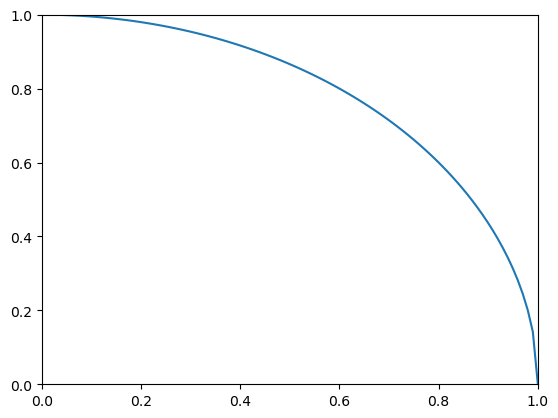

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# plot a quarter of the unit circle
x = np.linspace(0, 1.0, 100)
plt.plot(x, (1 - x ** 2) ** 0.5)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

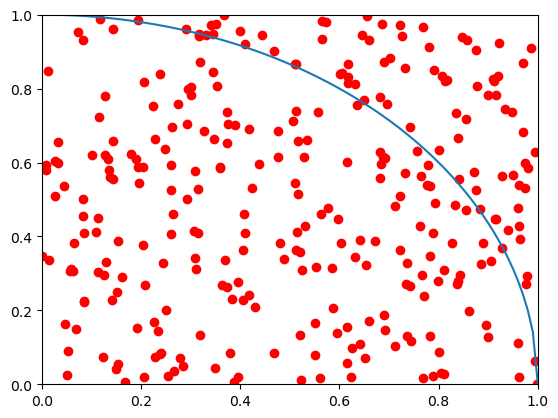

In [2]:
#plot random points

number_of_points = 300
plt.plot(np.random.random(number_of_points), np.random.random(number_of_points), 'ro')

# plot a quarter of the unit circle
x = np.linspace(0, 1.0, 100)
plt.plot(x, np.sqrt(1 - x ** 2))

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

### Prob(a ranodm point belongs to the 1/4-unit-circle) = Area(1/4-unit-circle)/Area(unit-square) = Pi/4

In [3]:
import random
    
def inside_quarter_circle(x, y):
    """indicator that (x,y) belongs to the quarter of the circle"""
    return int(x ** 2 + y ** 2 <= 1.0)

def approx_pi_mc(number_of_points):
    """monte-carlo PI"""
    
    counter = 0
    
    for i in range(number_of_points):
        x = random.random()
        y = random.random()
        counter += inside_quarter_circle(x, y)
        
    pi_approx = 4 * counter / number_of_points 
    print("pi_approx:", pi_approx)
    return pi_approx

In [4]:
%timeit -n 1 -r 1 approx_pi_mc(1_000_000)

pi_approx: 3.143368
591 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
# cProfile and profile provide deterministic profiling
import cProfile
cProfile.run('approx_pi_mc(1_000_000)')

pi_approx: 3.143644
         3000045 function calls in 1.283 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1000000    0.527    0.000    0.527    0.000 4197877935.py:3(inside_quarter_circle)
        1    0.607    0.607    1.283    1.283 4197877935.py:7(approx_pi_mc)
        1    0.000    0.000    1.283    1.283 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 iostream.py:127(_event_pipe)
        1    0.000    0.000    0.000    0.000 iostream.py:243(schedule)
        4    0.000    0.000    0.000    0.000 iostream.py:505(_is_master_process)
        4    0.000    0.000    0.000    0.000 iostream.py:532(_schedule_flush)
        4    0.000    0.000    0.000    0.000 iostream.py:610(write)
        1    0.000    0.000    0.000    0.000 socket.py:543(send)
        1    0.000    0.000    0.000    0.000 threading.py:1118(_wait_for_tstate_lock)
        1    0.000    0.000    0.000    0.000 threading.py:1185(is_ali

In [7]:
# run a code with the profiler

#%prun is a specific magic command to evaluate how much time your function or program to execute each function.

%prun approx_pi_mc(1_000_000)

pi_approx: 3.142336
 

Sometimes the cause of the hotspot is a single line in a function, which may not be obvious from reading the source code or analyzing the output of cProfile.

The __line_profiler__ times the execution of each individual line inside a function. The __line_profiler__ can be used by loading in Jupyer as:

In [3]:
# pip install line-profiler

In [8]:
%load_ext line_profiler

In [9]:
# run code with the line-by-line profiler
%lprun -f approx_pi_mc approx_pi_mc(1_000_000)

# -f : tells which function to profile

pi_approx: 3.1432


In [29]:
def approx_pi_mc_faster(total_number):
    
    # generate a vector of random points
    random_vect = np.random.rand(total_number, 2)
    
    # check if points belong to the circle
    bool_inside = random_vect[:, 0] ** 2 + random_vect[:, 1] ** 2 <= 1
    
    # count those
    # counter = sum(bool_inside)
    counter = np.sum(bool_inside, dtype=np.int32)
    
    pi_approx = 4 * counter / total_number 
    print("pi_approx:", pi_approx)
    return pi_approx

In [30]:
# %prun approx_pi_mc_faster(1_000_000)

%lprun -f approx_pi_mc_faster approx_pi_mc_faster(1_000_000)


pi_approx: 3.146088


In [13]:
# return random number between 0, 1
tmp = random.random()
print(tmp.__abs__())
# dir(tmp)  ## all the methods

0.8192790368849131


## Performance Tuning -- Line Profiling  

#### Example: Heat Equation

#### How does the heat transfer?   

#### Finite Element Methods


Consider a function (concretely temperature) $f = f(x, y, t)$ which depends on $(x,y) \in [0,1] \times [0,1]$ and time $t \geq 0$. 

Temperature satisfies the __heat equation__ (https://en.wikipedia.org/wiki/Heat_equation):
$$
\frac{\partial f}{\partial t} = \alpha^2 \left(\frac{\partial^2 f}{ \partial x^2} + \frac{\partial^2 f}{ \partial y^2} \right) \,.
$$

The rate at which the temperature changes $\frac{\partial f}{\partial t}$ is proportional to the 
Laplacian of the temperature function $\left(\frac{\partial^2 f}{ \partial x^2} + \frac{\partial^2 f}{ \partial y^2} \right)$.

In steady state $\partial f/\partial t = 0$, so (the __Poisson equation__):
$$
\frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2}=0.
$$

By using central difference in a square $[0,1]\times[0,1]$ regular grid:
$$
\frac{\partial^2 f}{\partial x^2}\approx\frac{f_{i+1,j}-2f_{i,j}+f_{i-1,j}}{\Delta x^2}\,,
$$

$$
\frac{\partial^2 f}{\partial y^2}\approx\frac{f_{i,j+1}-2f_{i,j}+f_{i,j-1}}{\Delta y^2}\,.
$$

We will assume $\Delta x = \Delta y$, so it follows:
$$
f_{i,j} = \frac{f_{i+1,j}+f_{i-1,j} + f_{i,j+1} + f_{i,j-1}}{4} \,.
$$

We will also assume that $f$ is known on the boundary of the square domain.








In [15]:
from itertools import product
import numpy as np

def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n, n))
    return G

def set_boundary_grid(G):
    '''set the boundary values'''
    n = G.shape[0]
    G[:, 0]  = np.ones((1, n))
    G[0, :]  = np.ones((1, n)) 
    G[-1, :] = np.ones((1, n))
    G[:, -1] = np.ones((1, n))
    

In [16]:
import matplotlib.pyplot as plt

def plot_grid(G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()
    

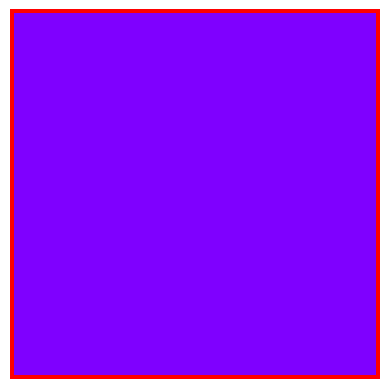

In [22]:
size_of_grid = 100

G = build_grid(n=size_of_grid)
set_boundary_grid(G)
plot_grid(G)    

In [27]:
# using two-loops
def iteration_loops(G):
    n = G.shape[0]
    for i in range(1, n-1):
        for j in range(1, n-1):
            # calculate the average
            G[i, j] = (G[i + 1, j] + G[i - 1, j] + G[i, j + 1] + G[i, j - 1]) / 4    


# using iterators to traverse the grid
def iteration_gen(G):
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        G[e]=(G[e[0] + 1, e[1]] + G[e[0] - 1, e[1]] + G[e[0], e[1] + 1] + G[e[0], e[1] - 1])/4
    

In [44]:
# auxiliary functions:

# calculate error between G1 and G2
def calc_error(G1, G2):
    error = 0
    n = G1.shape[0]
    for i in range(n):
        for j in range(n):
            error += (G1[i, j] - G2[i, j]) ** 2    
    # normalize the error
    return error / n**2


# using numpy built-in functions to compute the error
def calc_error_np(G1, G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return error


# deep copy of G1 to G2
def copy_array(G1, G2):
    G2[:, :] = G1[:, :]


In [45]:
def solve_heat_equation1(n):
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)

    error = float("inf")
    while error > 1e-7:
        iteration_loops(G)
        error = calc_error(G, G_prev)
        copy_array(G, G_prev)         
    return G

In [46]:
%lprun -f solve_heat_equation1 G1 = solve_heat_equation1(size_of_grid)

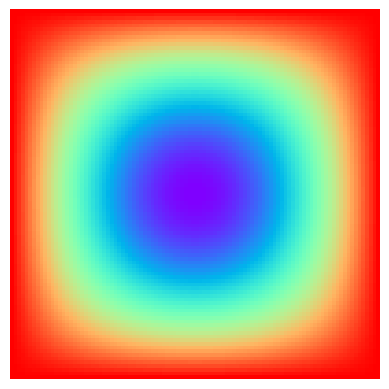

In [47]:
plot_grid(G1)

In [48]:
def solve_heat_equation2(n):
    '''changing to calc_error_np function'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.float64("inf")
    while error > 1e-7:
        iteration_loops(G)
        error = calc_error_np(G,G_prev) 
        copy_array(G,G_prev)    
        
    return G

In [49]:
%lprun -f solve_heat_equation2 G2 = solve_heat_equation2(size_of_grid)

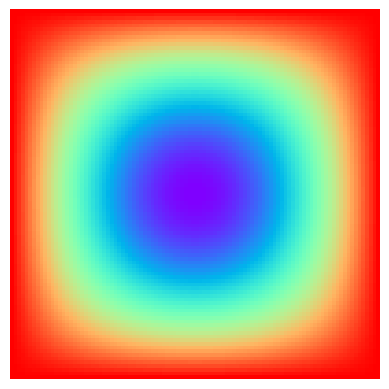

In [50]:
plot_grid(G2)

In [51]:
def solve_heat_equation3(n):
    '''changing to iteration_gen function'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = float("inf")
    while error > 1e-7:
        iteration_gen(G)
        error = calc_error(G,G_prev) 
        copy_array(G, G_prev)    
        
    return(G)

In [52]:
%lprun -f solve_heat_equation3 G3 = solve_heat_equation3(size_of_grid)

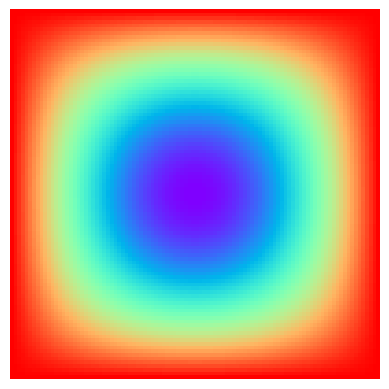

In [53]:
plot_grid(G3)

In [58]:
def solve_heat_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = float("inf")
    while error > 1e-7:
        iteration_gen(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return G

In [56]:
%lprun -f solve_heat_equation4 G4 = solve_heat_equation4(size_of_grid)

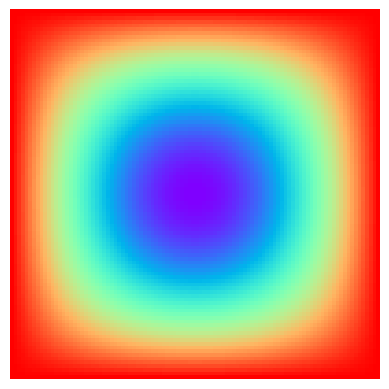

In [57]:
plot_grid(G4)

In [59]:
# different update (synchronous instead of asynchronous) but using only numpy
def iteration_np(G):
    n = G.shape[0]
    G[1:n-1,1:n-1] = (G[:n-2,1:n-1] + G[2:,1:n-1] + G[1:n-1,:n-2] + G[1:n-1,2:]) / 4

In [60]:
def solve_heat_equation5(n):
    '''all using numpy'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.inf
    while error > 1e-7:
        iteration_np(G)
        error = calc_error_np(G, G_prev)
        copy_array(G, G_prev)
    return G

In [61]:
%lprun -f solve_heat_equation5 G5 = solve_heat_equation5(size_of_grid)

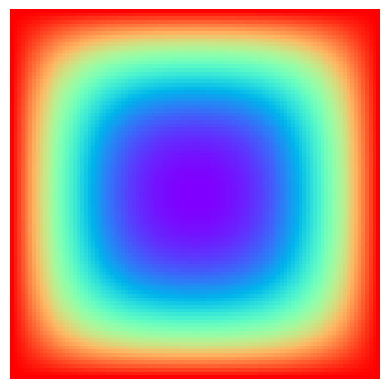

In [62]:
plot_grid(G5)